In [157]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import logging
import matplotlib.pyplot as plt

In [115]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %I:%M:%S %p %Z'
)
logging.info("Corrected Full Ensemble MLP-RF Script started at 12:15 PM IST on Thursday, June 12, 2025")

# Paths
metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
data_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"


2025-06-12 12:05:22 PM India Standard Time - INFO - Corrected Full Ensemble MLP-RF Script started at 12:15 PM IST on Thursday, June 12, 2025


In [117]:
# Load metadata and ensure Re is numeric
try:
    metadata = pd.read_csv(metadata_path)
    if 'Re' not in metadata.columns:
        logging.error("Re column not found in metadata")
        raise ValueError("Re column missing in metadata")
    metadata['Re'] = pd.to_numeric(metadata['Re'], errors='coerce')
    logging.info("Metadata Re column dtype after conversion:")
    logging.info(metadata['Re'].dtype)
    logging.info("Unique Re values in metadata:")
    logging.info(metadata['Re'].unique())
except FileNotFoundError:
    logging.error(f"Metadata file not found at {metadata_path}")
    raise

# Filter for B0005 and add cycle_index
metadata_filtered = metadata[metadata['battery_id'] == 'B0005'].copy()
metadata_filtered['cycle_index'] = range(len(metadata_filtered))
logging.info(f"Added cycle_index to metadata_filtered. Shape: {metadata_filtered.shape}")


2025-06-12 12:05:46 PM India Standard Time - INFO - Metadata Re column dtype after conversion:
2025-06-12 12:05:46 PM India Standard Time - INFO - float64
2025-06-12 12:05:46 PM India Standard Time - INFO - Unique Re values in metadata:
2025-06-12 12:05:46 PM India Standard Time - INFO - [       nan 0.05605783 0.05319186 ... 0.09778722 0.09867936 0.0968088 ]
2025-06-12 12:05:46 PM India Standard Time - INFO - Added cycle_index to metadata_filtered. Shape: (616, 11)


In [119]:
# Propagate Re values
def propagate_re_values(df, initial_re=0.073589):
    current_re = float(initial_re)
    re_values = []
    for idx, row in df.iterrows():
        if row['type'] == 'impedance':
            current_re = float(row['Re']) if not pd.isna(row['Re']) else current_re
        re_values.append(current_re)
    df['Re_propagated'] = re_values
    return df

metadata_filtered = propagate_re_values(metadata_filtered, initial_re=0.073589)
logging.info(f"Total rows after filtering: {len(metadata_filtered)}")
logging.info(f"Rows with valid propagated Re: {metadata_filtered['Re_propagated'].notna().sum()}")
logging.info(f"Rows with missing propagated Re: {metadata_filtered['Re_propagated'].isna().sum()}")

if metadata_filtered['Re_propagated'].isna().sum() > 0:
    logging.error("Some rows still have missing Re values after propagation.")
    raise ValueError("Propagation failed: Some rows still have missing Re values.")

2025-06-12 12:06:11 PM India Standard Time - INFO - Total rows after filtering: 616
2025-06-12 12:06:11 PM India Standard Time - INFO - Rows with valid propagated Re: 616
2025-06-12 12:06:11 PM India Standard Time - INFO - Rows with missing propagated Re: 0


In [121]:
# Function to parse complex numbers and return magnitude
def parse_complex(value):
    try:
        if isinstance(value, complex):
            return abs(value)
        if isinstance(value, str):
            value = value.strip('()')
            if 'j' in value:
                if 'e' in value:
                    parts = value.split('j')
                    real_part = float(parts[0].split('-')[0]) if '-' in parts[0] else float(parts[0])
                    imag_part = parts[1].replace('j', '')
                    if imag_part:
                        if imag_part.startswith('-'):
                            imag_part = float(imag_part)
                        else:
                            imag_part = float(imag_part) if imag_part else 0.0
                    else:
                        imag_part = 0.0
                    return abs(complex(real_part, imag_part))
                else:
                    if '+' in value:
                        real, imag = value.split('+')
                    else:
                        parts = value.split('-')
                        real = parts[0] if parts[0] else '0'
                        imag = '-' + parts[1] if len(parts) > 1 else '0'
                        if len(parts) == 3:
                            real = '-' + parts[1]
                            imag = '-' + parts[2]
                    real = float(real) if real else 0.0
                    imag = float(imag.replace('j', '')) if imag else 0.0
                    return abs(complex(real, imag))
        return float(value)
    except (ValueError, TypeError) as e:
        logging.warning(f"Could not parse complex value {value}: {str(e)}")
        return np.nan


In [123]:
# Function to extract features for charge/discharge cycles
def extract_features_charge_discharge(filepath, re_value, cycle_type, cycle_index):
    try:
        df = pd.read_csv(filepath)
        required_columns = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time']
        if not all(col in df.columns for col in required_columns):
            logging.warning(f"Missing required columns in {filepath}: Found {df.columns.tolist()}")
            return None

        for col in required_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        if df[required_columns].isna().any().any():
            logging.warning(f"Non-numeric values found in {filepath} after conversion.")

        df['Power'] = df['Voltage_measured'] * df['Current_measured']
        energy = np.trapz(df['Power'], x=df['Time']) if not df['Power'].isna().any() and not df['Time'].isna().any() else np.nan
        duration = df['Time'].iloc[-1] - df['Time'].iloc[0] if not df['Time'].isna().any() else np.nan

        features = {
            'avg_current': df['Current_measured'].mean(),
            'min_current': df['Current_measured'].min(),
            'avg_voltage': df['Voltage_measured'].mean(),
            'max_voltage': df['Voltage_measured'].max(),
            'min_voltage': df['Voltage_measured'].min(),
            'std_voltage': df['Voltage_measured'].std(),
            'avg_temperature': df['Temperature_measured'].mean(),
            'max_temperature': df['Temperature_measured'].max(),
            'min_temperature': df['Temperature_measured'].min(),
            'temp_range': df['Temperature_measured'].max() - df['Temperature_measured'].min(),
            'voltage_range': df['Voltage_measured'].max() - df['Voltage_measured'].min(),
            'duration': duration,
            'energy': energy,
            'avg_impedance': np.nan,
            'Re': re_value,
            'cycle_index': cycle_index
        }
        logging.info(f"Successfully extracted features from {filepath} (type: {cycle_type})")
        return features
    except Exception as e:
        logging.error(f"Error processing {filepath}: {str(e)}")
        return None

In [125]:
# Function to extract features for impedance cycles
def extract_features_impedance(filepath, re_value, cycle_type, cycle_index):
    try:
        df = pd.read_csv(filepath)
        required_columns = ['Battery_impedance']
        if not all(col in df.columns for col in required_columns):
            logging.warning(f"Missing required columns in {filepath}: Found {df.columns.tolist()}")
            return None

        df['Battery_impedance'] = df['Battery_impedance'].apply(parse_complex)
        avg_impedance = df['Battery_impedance'].mean() if 'Battery_impedance' in df.columns else np.nan

        features = {
            'avg_current': np.nan,
            'min_current': np.nan,
            'avg_voltage': np.nan,
            'max_voltage': np.nan,
            'min_voltage': np.nan,
            'std_voltage': np.nan,
            'avg_temperature': np.nan,
            'max_temperature': np.nan,
            'min_temperature': np.nan,
            'temp_range': np.nan,
            'voltage_range': np.nan,
            'duration': np.nan,
            'energy': np.nan,
            'avg_impedance': avg_impedance,
            'Re': re_value,
            'cycle_index': cycle_index
        }
        logging.info(f"Successfully extracted features from {filepath} (type: {cycle_type})")
        return features
    except Exception as e:
        logging.error(f"Error processing {filepath}: {str(e)}")
        return None

In [127]:
# Extract features for each file
features_list = []
processed_files = []
skipped_files = []

for idx, row in metadata_filtered.iterrows():
    csv_name = row['filename']
    cycle_type = row['type']
    full_path = os.path.join(data_folder, csv_name)
    re_value = row['Re_propagated']
    cycle_index = row['cycle_index']

    if not os.path.exists(full_path):
        logging.warning(f"File not found: {full_path}")
        skipped_files.append(csv_name)
        continue

    if cycle_type in ['charge', 'discharge']:
        features = extract_features_charge_discharge(full_path, re_value, cycle_type, cycle_index)
    else:  # impedance
        features = extract_features_impedance(full_path, re_value, cycle_type, cycle_index)

    if features:
        features_list.append(features)
        processed_files.append(csv_name)
    else:
        skipped_files.append(csv_name)

logging.info(f"Processed {len(processed_files)} files: {processed_files}")
logging.info(f"Skipped {len(skipped_files)} files: {skipped_files}")

2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05121.csv (type: charge)
2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05122.csv (type: discharge)
2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05123.csv (type: charge)
2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05124.csv (type: discharge)
2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05125.csv (type: charge)
2025-06-12 12:08:44 PM India Standard Time - INFO - Successfully extracted features from D:\NASA_Battery_Dataset\cleaned_dataset\data\05126.csv (type: discharge)
2025-06-12 12:08:44 PM India Standard

In [129]:
# Create DataFrame
features_df = pd.DataFrame(features_list)
if features_df.empty:
    logging.error("No valid features extracted. Check logs for details.")
    raise ValueError("No valid features extracted.")

# Ensure Re and cycle_index columns are numeric
features_df['Re'] = pd.to_numeric(features_df['Re'], errors='coerce')
features_df['cycle_index'] = pd.to_numeric(features_df['cycle_index'], errors='coerce')
logging.info("features_df Re column dtype after conversion:")
logging.info(features_df['Re'].dtype)
logging.info("Unique Re values in features_df:")
logging.info(features_df['Re'].unique())

# Drop low-importance features
features_df = features_df.drop(columns=['duration', 'min_voltage', 'avg_current', 'temp_range', 'voltage_range'], errors='ignore')

2025-06-12 12:09:07 PM India Standard Time - INFO - features_df Re column dtype after conversion:
2025-06-12 12:09:07 PM India Standard Time - INFO - float64
2025-06-12 12:09:07 PM India Standard Time - INFO - Unique Re values in features_df:
2025-06-12 12:09:07 PM India Standard Time - INFO - [0.073589   0.0446687  0.046687   0.04484343 0.04619469 0.04510115
 0.04599074 0.04417208 0.04521711 0.04378663 0.04490995 0.04463932
 0.04717044 0.04355879 0.0464897  0.04526548 0.04636224 0.04448372
 0.04482791 0.04441416 0.04466451 0.04453545 0.04502135 0.04610647
 0.04646252 0.04766732 0.04772385 0.0478677  0.04694023 0.04561342
 0.04702798 0.04672887 0.04775538 0.04691623 0.04702294 0.04660479
 0.04624537 0.04683294 0.0461861  0.04624137 0.04773737 0.04942748
 0.04838334 0.04747842 0.04803751 0.04770362 0.04808696 0.04815105
 0.04754728 0.04759013 0.04764092 0.04764024 0.04842437 0.04893386
 0.04943075 0.04932301 0.04974823 0.04912203 0.04988487 0.04785945
 0.04921638 0.04887229 0.04994594 0

In [131]:
# Ensure avg_impedance exists
if 'avg_impedance' not in features_df.columns:
    features_df['avg_impedance'] = np.nan

# Add lagged Re features
features_df['Re_lag1'] = features_df['Re'].shift(1).fillna(features_df['Re'].iloc[0])
features_df['Re_lag2'] = features_df['Re'].shift(2).fillna(features_df['Re'].iloc[1])
logging.info("Added lagged Re features (Re_lag1, Re_lag2)")

# Convert all feature columns to numeric
numeric_cols = [col for col in features_df.columns if col not in ['Re']]
for col in numeric_cols:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# Handle missing values by forward filling
features_df[numeric_cols] = features_df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
logging.info("Columns with NaNs after filling:")
logging.info(features_df[numeric_cols].isna().sum())

2025-06-12 12:09:28 PM India Standard Time - INFO - Added lagged Re features (Re_lag1, Re_lag2)
C:\Users\AK\AppData\Local\Temp\ipykernel_11308\557435385.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df[numeric_cols] = features_df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
2025-06-12 12:09:28 PM India Standard Time - INFO - Columns with NaNs after filling:
2025-06-12 12:09:28 PM India Standard Time - INFO - min_current        0
avg_voltage        0
max_voltage        0
std_voltage        0
avg_temperature    0
max_temperature    0
min_temperature    0
energy             0
avg_impedance      0
cycle_index        0
Re_lag1            0
Re_lag2            0
dtype: int64


In [133]:
# Remove outliers using IQR with a softer threshold
def remove_outliers(df, column, multiplier=6.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    dropped_rows = df[~df.index.isin(filtered_df.index)]
    if not dropped_rows.empty:
        logging.info(f"Dropped rows due to outliers in {column}:")
        logging.info(dropped_rows[['Re', column]])
    return filtered_df

numeric_cols_for_outliers = [col for col in numeric_cols if col != 'Re']
for col in numeric_cols_for_outliers:
    features_df = remove_outliers(features_df, col, multiplier=6.0)

logging.info(f"Features DataFrame shape after preprocessing: {features_df.shape}")

2025-06-12 12:09:49 PM India Standard Time - INFO - Dropped rows due to outliers in max_voltage:
2025-06-12 12:09:49 PM India Standard Time - INFO -            Re  max_voltage
84   0.045021     8.393141
615  0.050036     4.985137
2025-06-12 12:09:49 PM India Standard Time - INFO - Features DataFrame shape after preprocessing: (614, 13)


In [135]:
# Sort by cycle_index and reset index to avoid index mismatch
features_df = features_df.sort_values('cycle_index').reset_index(drop=True)

# Prepare data for modeling
X = features_df.drop(columns='Re')
y = features_df['Re']

# Normalize features with RobustScaler, preserving the index
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
logging.info("Features scaled using RobustScaler")

# Chronological split (80% train, 20% test) using positional indexing
train_size = int(0.8 * len(X_scaled))
X_train = X_scaled.iloc[:train_size]
X_test = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]
logging.info(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

2025-06-12 12:10:16 PM India Standard Time - INFO - Features scaled using RobustScaler
2025-06-12 12:10:16 PM India Standard Time - INFO - Train set size: 491, Test set size: 123


In [137]:
# MLP Model with hyperparameter tuning
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [1000]
}
model_mlp = MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.2)
grid_search_mlp = GridSearchCV(
    model_mlp, param_grid_mlp, cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search_mlp.fit(X_train, y_train)
best_model_mlp = grid_search_mlp.best_estimator_
logging.info(f"Best MLP hyperparameters: {grid_search_mlp.best_params_}")

2025-06-12 12:13:43 PM India Standard Time - INFO - Best MLP hyperparameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}


In [159]:
# Cross-validation for MLP
cv_mlp = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mlp = cross_val_score(best_model_mlp, X_scaled, y, cv=cv_mlp, scoring='r2')
logging.info(f"MLP Cross-validation R² scores: {cv_scores_mlp}")
logging.info(f"MLP Average CV R²: {cv_scores_mlp.mean():.5f} ± {cv_scores_mlp.std():.5f}")


2025-06-12 12:41:09 PM India Standard Time - INFO - MLP Cross-validation R² scores: [0.97349045 0.96699106 0.96987894 0.9613566  0.84723005]
2025-06-12 12:41:09 PM India Standard Time - INFO - MLP Average CV R²: 0.94379 ± 0.04844


In [141]:
# Random Forest Model with hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(
    model_rf, param_grid_rf, cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_
logging.info(f"Best Random Forest hyperparameters: {grid_search_rf.best_params_}")

2025-06-12 12:15:48 PM India Standard Time - INFO - Best Random Forest hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [161]:
# Cross-validation for Random Forest
cv_rf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(best_model_rf, X_scaled, y, cv=cv_rf, scoring='r2')
logging.info(f"Random Forest Cross-validation R² scores: {cv_scores_rf}")
logging.info(f"Random Forest Average CV R²: {cv_scores_rf.mean():.5f} ± {cv_scores_rf.std():.5f}")

2025-06-12 12:41:22 PM India Standard Time - INFO - Random Forest Cross-validation R² scores: [0.98537884 0.98478218 0.97492365 0.97892089 0.8578788 ]
2025-06-12 12:41:22 PM India Standard Time - INFO - Random Forest Average CV R²: 0.95638 ± 0.04940


In [145]:
# Ensemble predictions (weighted average: 60% RF, 40% MLP)
y_pred_mlp = best_model_mlp.predict(X_test)
y_pred_rf = best_model_rf.predict(X_test)
y_pred_ensemble = 0.6 * y_pred_rf + 0.4 * y_pred_mlp

In [155]:
# Evaluate ensemble model
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2_ensemble = r2_score(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

print(f"✅ Ensemble (MLP + RF) Model Evaluation on Test Set:")
print(f"RMSE = {rmse_ensemble:.7f}")
print(f"R²   = {r2_ensemble:.7f}")
print(f"MAE  = {mae_ensemble:.7f}")
print(f"MSE  = {mse_ensemble:.7f}")

✅ Ensemble (MLP + RF) Model Evaluation on Test Set:
RMSE = 0.0016206
R²   = 0.5545874
MAE  = 0.0009947
MSE  = 0.0000026


In [149]:
# Feature Importance for Ensemble (average permutation importance)
perm_importance_mlp = permutation_importance(best_model_mlp, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_rf = permutation_importance(best_model_rf, X_test, y_test, n_repeats=10, random_state=42)
feature_importance_ensemble = pd.DataFrame({
    'Feature': X.columns,
    'Importance': 0.6 * perm_importance_rf.importances_mean + 0.4 * perm_importance_mlp.importances_mean
}).sort_values(by='Importance', ascending=False)
print("\n📌 Ensemble Feature Importance (Permutation Importance):")
print(feature_importance_ensemble)


📌 Ensemble Feature Importance (Permutation Importance):
            Feature  Importance
1       avg_voltage    1.344166
10          Re_lag1    0.889325
0       min_current    0.756279
7            energy    0.506049
4   avg_temperature    0.316875
8     avg_impedance    0.159869
5   max_temperature    0.149435
9       cycle_index    0.003047
2       max_voltage    0.000343
6   min_temperature   -0.002170
3       std_voltage   -0.007971
11          Re_lag2   -0.011475


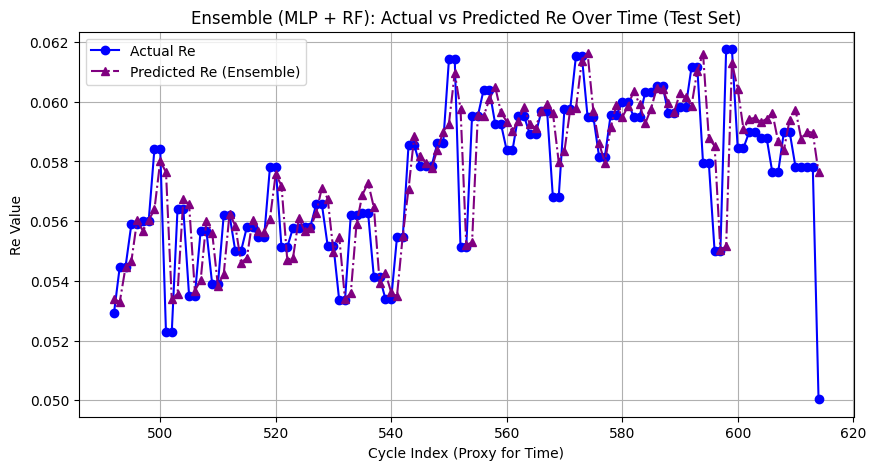

In [163]:
# Plot actual vs predicted over time
X_test_with_index = X_test.copy()
X_test_with_index['cycle_index'] = features_df['cycle_index'].iloc[train_size:].values
X_test_with_index['y_test'] = y_test.values
X_test_with_index['y_pred_ensemble'] = y_pred_ensemble
X_test_with_index = X_test_with_index.sort_values(by='cycle_index')

plt.figure(figsize=(10, 5))
plt.plot(X_test_with_index['cycle_index'], X_test_with_index['y_test'], marker='o', linestyle='-', color='blue', label='Actual Re')
plt.plot(X_test_with_index['cycle_index'], X_test_with_index['y_pred_ensemble'], marker='^', linestyle='-.', color='purple', label='Predicted Re (Ensemble)')
plt.xlabel('Cycle Index (Proxy for Time)')
plt.ylabel('Re Value')
plt.title('Ensemble (MLP + RF): Actual vs Predicted Re Over Time (Test Set)')
plt.grid(True)
plt.legend()
plt.show()

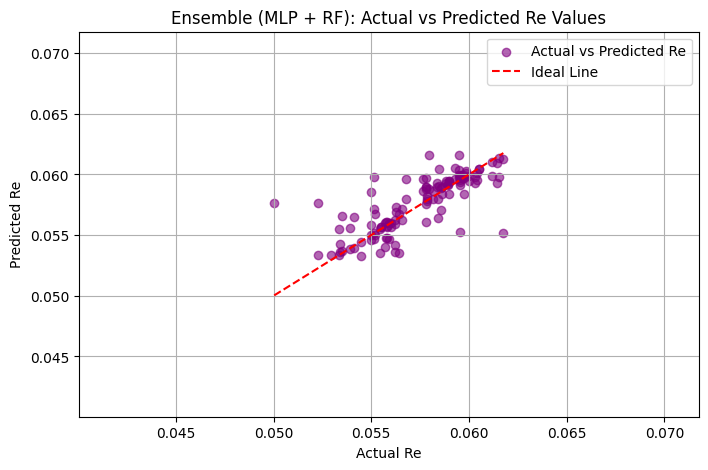

In [165]:
# Scatter plot: Actual vs Predicted Re
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ensemble, color='purple', alpha=0.6, label='Actual vs Predicted Re')
min_val = min(np.min(y_test), np.min(y_pred_ensemble))
max_val = max(np.max(y_test), np.max(y_pred_ensemble))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Re')
plt.ylabel('Predicted Re')
plt.title('Ensemble (MLP + RF): Actual vs Predicted Re Values')
plt.legend()
plt.grid(True)
plt.xlim(min_val - 0.01, max_val + 0.01)
plt.ylim(min_val - 0.01, max_val + 0.01)
plt.show()